In [1]:
import os
os.environ['PYTHONHASHSEED'] = '0'
import random as rn
rn.seed(12345)
from numpy.random import seed
seed(42)

import warnings
warnings.filterwarnings('ignore')

import yaml

import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib

from scipy import interpolate
from mpl_toolkits.mplot3d import Axes3D
from hashlib import md5
from nibabel.streamlines.tractogram import Tractogram, PerArraySequenceDict
from nibabel.streamlines.trk import TrkFile
from nibabel.streamlines.array_sequence import ArraySequence

In [2]:
def fiber_geometry(fiber, n_pts="auto", smoothing=1):
    """
    fiber: [[x1,y1,z1],...,[xn,yn,zn]]
    """
    
    tck, u = interpolate.splprep(fiber.T.reshape(3, -1), s=smoothing)

    if n_pts == "auto":
        flen = np.linalg.norm(fiber[1:] - fiber[:-1], axis=1).sum()
        n_pts = int(flen/2) # if units are in mm, pts are on average 2 mm apart

    pts = np.linspace(0, 1, n_pts) # Use u to get samples exactly at the observed points

    r = np.dstack(interpolate.splev(pts, tck))[0]
    r1 = np.dstack(interpolate.splev(pts, tck, der=1))[0]
    r2 = np.dstack(interpolate.splev(pts, tck, der=2))[0]
    r3 = np.dstack(interpolate.splev(pts, tck, der=3))[0]
    
    r1xr2 = np.cross(r1, r2)

    t = r1
    t /= np.linalg.norm(t, axis=1, keepdims=True)

    b = r1xr2
    b /= np.linalg.norm(b, axis=1, keepdims=True)

    n = np.cross(b, t)

    k = np.linalg.norm(r1xr2, axis=1, keepdims=True)
    k /= np.linalg.norm(r1, axis=1, keepdims=True)**3

    tau = np.sum(r1xr2 * r3, axis=1, keepdims=True)
    tau /= np.linalg.norm(r1xr2, axis=1, keepdims=True)**2
    
    return r, t, b, n, k, tau, n_pts

In [3]:
def resample(config):
    
    subject_dir = os.path.join("subjects", config["subject"])
    
    save_dir = os.path.join(subject_dir, "resampled_fibers")
    
    save_path = os.path.join(save_dir,
                             "{}_smooth={}_npts={}.trk".format(config["bundle"],
                                                               config["smoothing"],
                                                               config["n_pts"]))
    if os.path.exists(save_path):
        print("Resampling with this config has been performed already:\n{}".format(save_path))
        return
    
    trk_path = os.path.join(subject_dir, "tracts", config["bundle"] + ".trk")
    trk_file = nib.streamlines.load(trk_path)
    fibers = trk_file.tractogram.streamlines
    
    position = ArraySequence()
    tangent = ArraySequence()
    binormal = ArraySequence()
    mainnormal = ArraySequence()
    curvature = ArraySequence()
    torsion = ArraySequence() 
    rows = 0
    
    def max_dist_from_mean(path):
        return np.linalg.norm(path - np.mean(path, axis=0, keepdims=True), axis=1).max()
    
    n_fails = 0
    for i, f in enumerate(fibers):
        r, t, b, n, k, tau, cnt = fiber_geometry(f, n_pts=config["n_pts"], smoothing=config["smoothing"])
        
        if max_dist_from_mean(r) > 1.2 * max_dist_from_mean(f):
            n_fails += 1
            continue
        
        position.append(r, cache_build=True)
        tangent.append(t, cache_build=True)
        binormal.append(b, cache_build=True)
        mainnormal.append(n, cache_build=True)
        curvature.append(k, cache_build=True)
        torsion.append(tau, cache_build=True)
        rows += cnt
        
        print("Finished {:3.0f}%".format(100*(i+1)/len(fibers)), end="\r")
    
    if n_fails > 0:
        print("Failed to resample {} out of {} fibers, they were not included.".format(n_fails, len(fibers)))
        
    position.finalize_append()
    tangent.finalize_append()
    binormal.finalize_append()
    mainnormal.finalize_append()
    curvature.finalize_append()
    torsion.finalize_append()
    
    data_per_point = PerArraySequenceDict(
        n_rows = rows,
        t = tangent,
        b = binormal,
        n = mainnormal,
        k = curvature,
        tau = torsion
    )
    
    tractogram = Tractogram(
        streamlines=position,
        data_per_point=data_per_point,
        affine_to_rasmm=np.eye(4) # Fiber coordinates are already in rasmm space!
    )
    
    os.makedirs(save_dir, exist_ok=True)
    print("Saving {}".format(save_path))
    TrkFile(tractogram, trk_file.header).save(save_path)
    
    return tractogram

In [4]:
config = dict(
    subject="917255",
    bundle="merged_w1",
    n_pts="auto",
    smoothing=5,
)

In [5]:
tractogram = resample(config)

Saving subjects/917255/resampled_fibers/merged_w1_smooth=5_npts=auto.trk


In [21]:
trk_file = nib.streamlines.load(
    os.path.join("subjects", config["subject"], "tracts", config["bundle"] + ".trk")
)

fibers = trk_file.tractogram.streamlines

In [6]:
# 3D example
def show(fiber, smoothing=5, n_pts=100):
    
    r, _, _, _, _, _, _ = fiber_geometry(fiber, n_pts=n_pts, smoothing=smoothing)
    
    fig2 = plt.figure(dpi=200)

    ax3d = fig2.add_subplot(111, projection='3d')
    ax3d.plot(fiber[:,0], fiber[:,1], fiber[:,2], 'b')
    ax3d.plot(r[:,0], r[:,1], r[:,2], 'xg')
    fig2.show()
    plt.show()

/local/home/vwegmayr/miniconda2/envs/thesis/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  # This is added back by InteractiveShellApp.init_path()


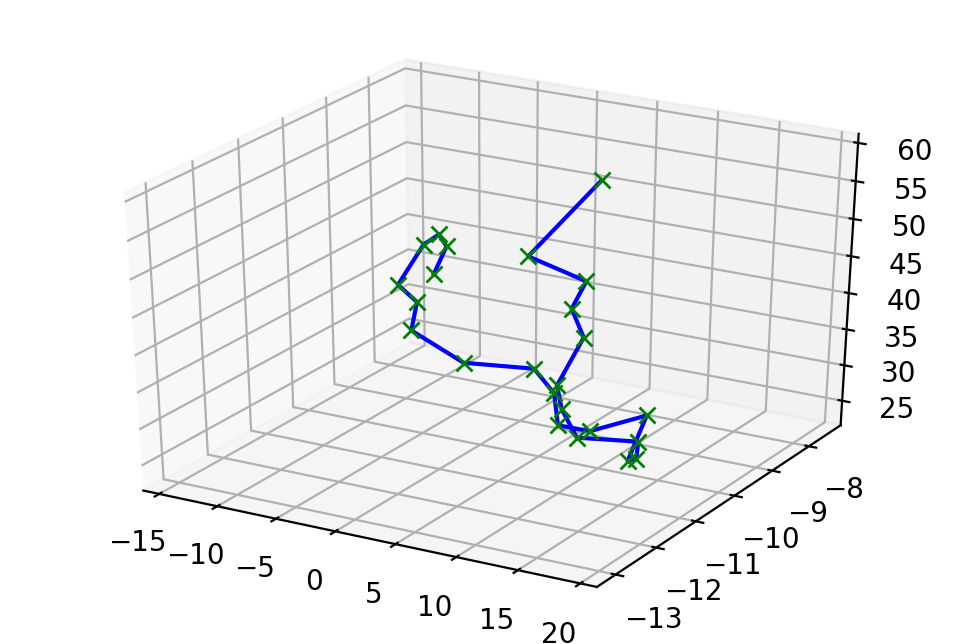

In [18]:
show(fibers[17], smoothing=0, n_pts="auto")